In [68]:
"""
# Resume Classification Pipeline
A comprehensive system for processing, classifying, and analyzing resumes
"""
# %%
# ======================
# 1. INITIAL SETUP
# ======================
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
import spacy

tqdm.pandas()  # Enable progress bars for pandas operations
nlp = spacy.load("en_core_web_sm")

In [73]:
"""
## Configuration
Centralized settings for the pipeline
"""
# %%
class Config:
    DATA_PATH = r"dataset\UpdatedResumeDataSet.csv"
    CATEGORIES = [
        'Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
        'Mechanical Engineer', 'Sales', 'Health and fitness',
        'Civil Engineer', 'Java Developer', 'Business Analyst',
        'SAP Developer', 'Automation Testing', 'Electrical Engineering',
        'Operations Manager', 'Python Developer', 'DevOps Engineer',
        'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
        'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'
    ]
    TEST_SIZE = 0.25
    RANDOM_STATE = 42
    NGRAM_RANGE = (1, 2)
    MAX_FEATURES = 5000

config = Config()

In [74]:
"""
## 2. DATA LOADING
Load and inspect the resume dataset
"""
# %%
df = pd.read_csv(config.DATA_PATH)
print(f"Dataset shape: {df.shape}")
df.head()


Dataset shape: (962, 2)


,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [75]:
# %% [markdown]
"""
## 3. TEXT PREPROCESSING
Clean and normalize resume text
"""
# %%
def clean_resume_text(text):
    """Custom text cleaning pipeline"""
    text = text.lower()
    text = re.sub(r'[^\w\s.]', '', text)  # Remove punctuation
    text = re.sub(r'(?i)(?<=\b[a-z])\.(?=[a-z]{2,}\b)', '', text)  # Handle abbreviations
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    text = re.sub(r'\r\n', ' ', text)  # Remove line breaks
    return text

# Apply cleaning with progress bar
df['CleanedResume'] = df['Resume'].progress_apply(clean_resume_text)
df[['Resume', 'CleanedResume']].head(2)

100%|███████████████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 984.88it/s]


,Resume,CleanedResume
0,Skills * Programming Languages: Python (pandas...,skills programming languages python pandas num...
1,Education Details \r\nMay 2013 to May 2017 B.E...,education details may 2013 to may 2017 b.e uit...


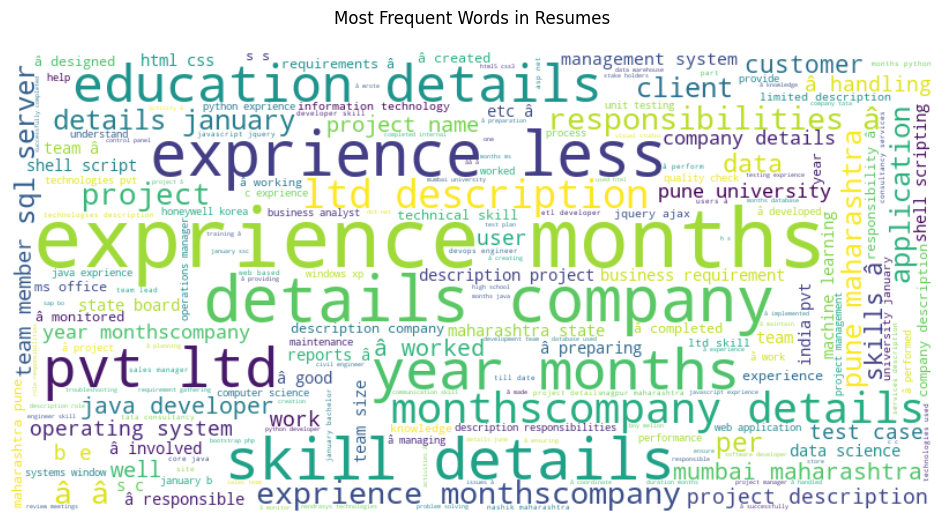

In [76]:
# %% [markdown]
"""
## 4. EXPLORATORY ANALYSIS
Visualize most common terms
"""
# %%
# Generate word cloud
all_text = ' '.join(df['CleanedResume'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in Resumes", pad=20)
plt.show()


In [77]:
# %% [markdown]
"""
## 5. FEATURE ENGINEERING
Convert text to numerical features
"""
# %%
# Encode categories
le = LabelEncoder()
df['CategoryCode'] = le.fit_transform(df['Category'])

# TF-IDF Vectorization
tfidf = TfidfVectorizer(
    ngram_range=config.NGRAM_RANGE,
    max_features=config.MAX_FEATURES,
    stop_words='english'
)
X = tfidf.fit_transform(df['CleanedResume'])
y = df['CategoryCode']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=config.TEST_SIZE,
    random_state=config.RANDOM_STATE
)

In [78]:
# %% [markdown]
"""
## 6. MODEL TRAINING
Build and evaluate classifier
"""
# %%
model = OneVsRestClassifier(
    LogisticRegression(
        max_iter=1000,
        class_weight='balanced'
    )
)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(
    y_test, y_pred,
    target_names=le.classes_
))

                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         6
                     Arts       1.00      1.00      1.00         8
       Automation Testing       1.00      1.00      1.00         6
               Blockchain       1.00      1.00      1.00        10
         Business Analyst       0.83      1.00      0.91         5
           Civil Engineer       1.00      1.00      1.00         9
             Data Science       1.00      1.00      1.00         9
                 Database       1.00      1.00      1.00         9
          DevOps Engineer       1.00      0.88      0.94        17
         DotNet Developer       1.00      1.00      1.00        10
            ETL Developer       1.00      1.00      1.00         7
   Electrical Engineering       1.00      1.00      1.00         7
                       HR       1.00      1.00      1.00        15
                   Hadoop       1.00      1.00      1.00     

In [79]:
# %% [markdown]
"""
## 7. INFORMATION EXTRACTION
Parse resumes for key details
"""
# %%
def extract_resume_details(text):
    """Enhanced information extraction"""
    doc = nlp(text)
    
    results = {
        'skills': set(),
        'companies': set(),
        'education': [],
        'experience': []
    }
    
    # Extract entities
    for ent in doc.ents:
        if ent.label_ == "ORG":
            results['companies'].add(ent.text)
        elif ent.label_ == "DATE" and any(x in ent.text for x in ['year', 'month']):
            results['experience'].append(ent.text)
    
    # Extract skills (simplified example)
    tech_skills = ['python', 'java', 'sql', 'machine learning', 'aws']
    for skill in tech_skills:
        if skill in text:
            results['skills'].add(skill)
    
    # Convert sets to lists for JSON serialization
    return {k: list(v) for k, v in results.items()}

# Example extraction
sample_resume = df['CleanedResume'].iloc[0]
extracted_info = extract_resume_details(sample_resume)
print("Extracted Information:")
extracted_info

Extracted Information:


{'skills': ['machine learning', 'sql', 'python', 'java'],
 'companies': [],
 'education': [],
 'experience': ['24 months', '24 months', 'past one year']}

In [80]:
# %% [markdown]
"""
## 8. PREDICTION PIPELINE
Complete processing for new resumes
"""
# %%
def analyze_resume(resume_text):
    """End-to-end processing"""
    # Clean text
    cleaned = clean_resume_text(resume_text)
    
    # Predict category
    features = tfidf.transform([cleaned])
    category = le.inverse_transform(model.predict(features))[0]
    
    # Extract details
    details = extract_resume_details(cleaned)
    
    return {
        'category': category,
        'details': details
    }

# Test pipeline
test_resume = df['Resume'].iloc[10]
analysis_result = analyze_resume(test_resume)
print("\nAnalysis Result:")
analysis_result


Analysis Result:


{'category': 'Data Science',
 'details': {'skills': ['machine learning', 'sql', 'python', 'java'],
  'companies': [],
  'education': [],
  'experience': ['24 months', '24 months', 'past one year']}}